### **Model 3: Neural Network**

**Libraries used:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch
import torchsummary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mps


**Getting the dataset ready:**

In [2]:
data = pd.read_csv('./Cleaning Data/cleaned_urdu_articles.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
print("Null Check:", data.isnull().sum().sum())
print("Shape:", data.shape)

X = data['Contents']
y = data['Gold Labels']
seed = 1234
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=seed) # 70% training data and 15% Validation and 15% Testing
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=seed) # 50% Validation and 50% Testing


label_set = set(y_train)
label_set = list(label_set)
def encode_labels(y):
    y_encoded = []
    for label in y:
        y_encoded.append(label_set.index(label))
    return np.array(y_encoded)

def decode_labels(y):
    y_decoded = []
    for label in y:
        y_decoded.append(label_set[label])
    return np.array(y_decoded)

y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)
y_test_encoded = encode_labels(y_test)

Null Check: 0
Shape: (1610, 5)


In [3]:
class Vector(): # Vectorizing the Text Data by creating a Vocabulary and then converting the text data into Vectors based on Count of Words
    def __init__(self, data):
        self.data = data
        self.vocab = {} # Key: Word, Value: Index in the vector
        self.vocab_size = 0
        for content in self.data:
            for word in content.split():
                if word not in self.vocab:
                    self.vocab[word] = self.vocab_size
                    self.vocab_size += 1
        print("Vocabulary Size:", self.vocab_size)
        
    def vectorize(self, content):
        vector = np.zeros(self.vocab_size)
        for word in content.split():
            if word in self.vocab:
                vector[self.vocab[word]] += 1
        return vector
    
    def vectorize_all(self, data):
        return np.array([self.vectorize(content) for content in data])
    
vectorizer = Vector(X_train)
X_train_vector = vectorizer.vectorize_all(X_train)
X_val_vector = vectorizer.vectorize_all(X_val)
X_test_vector = vectorizer.vectorize_all(X_test)
print("X_train_vector Shape:", X_train_vector.shape)
print("X_val_vector Shape:", X_val_vector.shape)
print("X_test_vector Shape:", X_test_vector.shape)

Vocabulary Size: 22798
X_train_vector Shape: (1288, 22798)
X_val_vector Shape: (161, 22798)
X_test_vector Shape: (161, 22798)


**Neural Network Class:**

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.hidden_1 = nn.Linear(input_size, 128)
        self.hidden_2 = nn.Linear(128, 64)
        self.hidden_3 = nn.Linear(64, 128)
        self.output = nn.Linear(128, 5)
        self.relu = nn.ReLU()
        self.classifier = nn.Sequential(
            self.hidden_1,
            self.relu,
            self.hidden_2,
            self.relu,
            self.hidden_3,
            self.relu,
            self.output
        )
        
    def forward(self, x):
        return self.classifier(x)

In [5]:
model = NeuralNet(vectorizer.vocab_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
summary = torchsummary.summary(model, (vectorizer.vocab_size,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5]                   --
├─Linear: 1-2                            [-1, 128]                 2,918,272
├─Sequential: 1                          []                        --
|    └─Linear: 2-1                       [-1, 128]                 (recursive)
├─ReLU: 1-3                              [-1, 128]                 --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-2                         [-1, 128]                 --
├─Linear: 1-4                            [-1, 64]                  8,256
├─Sequential: 1                          []                        --
|    └─Linear: 2-3                       [-1, 64]                  (recursive)
├─ReLU: 1-5                              [-1, 64]                  --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-4                         [-1, 64]        

In [6]:
## Write functions to train and evaluate the model (10+10+5 Marks)

def fit_one_epoch(model, X, y, optimizer, loss_fn):
    '''
    Perform one epoch of training
    '''
    model.train()
    train_loss = []
    correct = 0
    total = 0
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.int).to(device)
    contents = X
    labels = y
    for i in range(len(contents)):
        content = contents[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)
        outputs = model.to(device)(content)
        loss = loss_fn(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        predicted = torch.argmax(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    accuracy = correct / total
    return train_loss, accuracy

@torch.no_grad()
def evaluate(model, X, y, loss_fn, test=False):
    '''
    Perform one epoch of evaluation
    '''
    model.eval()    
    val_loss = []
    correct = 0
    total = 0
    predicted_labels = []
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.int).to(device)
    contents = X
    labels = y
    for i in range(len(contents)):
        content = contents[i].unsqueeze(0)
        label = labels[i].unsqueeze(0)
        outputs = model.to(device)(content)
        loss = loss_fn(outputs, label)
        val_loss.append(loss.item())
        predicted = torch.argmax(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        predicted_labels.append(predicted.item())
    accuracy = correct / total
    if test:
        return val_loss, accuracy, predicted_labels
    return val_loss, accuracy
    
def fit(model, X_train, y_train, X_val, y_val, optimizer, loss_fn, epochs):
    '''
    Perform the entire training process
    '''
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    for epoch in range(epochs):
        print('---------------------------------------------')
        print(f'Epoch: {epoch+1}')
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)
        print(f'Train Loss: {np.mean(train_loss)}')
        print(f'Training Accuracy: {train_acc}')
        train_losses.append(np.mean(train_loss))
        train_accuracy.append(train_acc)
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn)
        val_losses.append(np.mean(val_loss))
        val_accuracy.append(val_acc)
        print(f'Validation Loss: {np.mean(val_loss)}')
        print(f'Validation Accuracy: {val_acc}')
        if epoch == epochs - 1:
            print('---------------------------------------------')
            print('Training Complete')
            print('---------------------------------------------')
    return train_losses, val_losses, train_accuracy, val_accuracy

**Training the Neural Network:**

In [7]:
print("Training the Model")
print("X_train_vector Shape:", X_train_vector.shape)
print("y_train_encoded Shape:", y_train_encoded.shape)
print("X_test_vector Shape:", X_test_vector.shape)
print("y_test_encoded Shape:", y_test_encoded.shape)

train_losses, val_losses, train_accuracy, val_accuracy = \
fit(model, X_train_vector, y_train_encoded, X_val_vector, y_val_encoded, optimizer, criterion, 10)

Training the Model
X_train_vector Shape: (1288, 22798)
y_train_encoded Shape: (1288,)
X_test_vector Shape: (161, 22798)
y_test_encoded Shape: (161,)
---------------------------------------------
Epoch: 1
Train Loss: 0.7193376106696885
Training Accuracy: 0.8082298136645962
Validation Loss: 0.21933814358947548
Validation Accuracy: 0.937888198757764
---------------------------------------------
Epoch: 2
Train Loss: 0.34223596242332127
Training Accuracy: 0.9340062111801242
Validation Loss: 0.3895764741129126
Validation Accuracy: 0.9006211180124224
---------------------------------------------
Epoch: 3
Train Loss: 0.2434829324310616
Training Accuracy: 0.9596273291925466
Validation Loss: 0.3667268175673431
Validation Accuracy: 0.8944099378881988
---------------------------------------------
Epoch: 4
Train Loss: 0.22725201714036541
Training Accuracy: 0.9635093167701864
Validation Loss: 0.49643822491590717
Validation Accuracy: 0.906832298136646
---------------------------------------------
Epo

**Loss Curve and Accuracy Curve:**

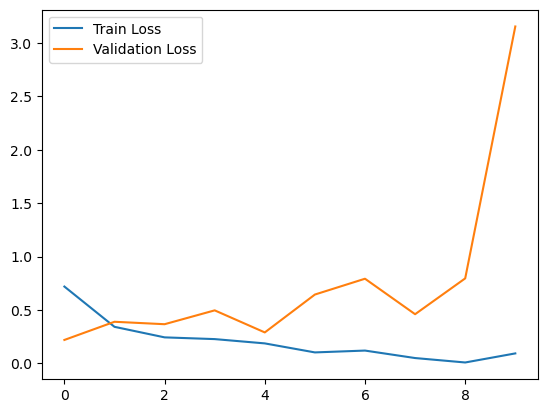

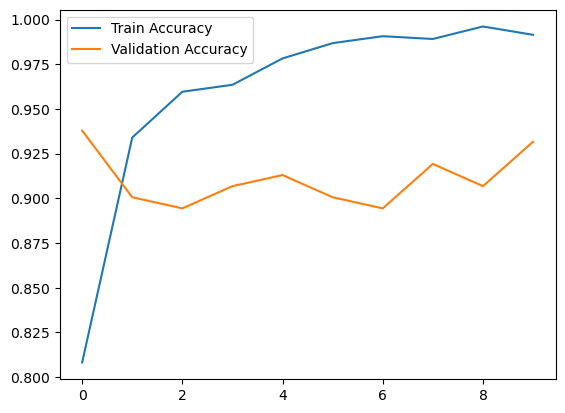

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()

**Predicting the output:**

Test Loss: 2.1844026169735966
Test Accuracy: 0.9316770186335404

RESULTS:
------------------------------------------------------------------------------------------
Accuracy: 0.9316770186335404
F1 Score: 0.9296602873482303
Recall: 0.9316770186335404
Precision: 0.9329114248881596
------------------------------------------------------------------------------------------
Confusion Matrix:


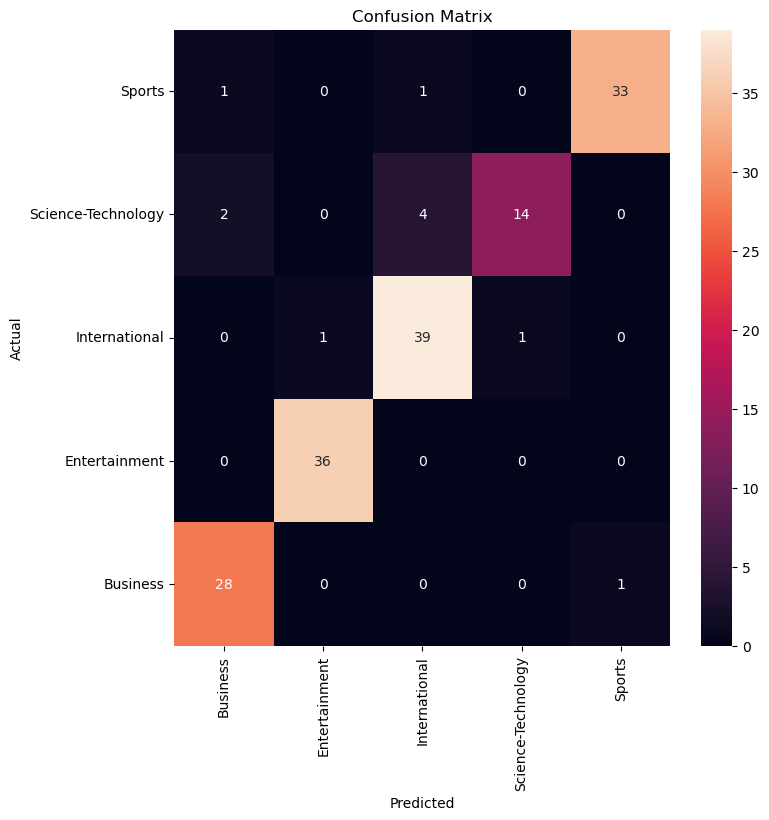

------------------------------------------------------------------------------------------
Classification Report:
                    precision    recall  f1-score   support

          Business       0.90      0.97      0.93        29
     Entertainment       0.97      1.00      0.99        36
     International       0.89      0.95      0.92        41
Science-Technology       0.93      0.70      0.80        20
            Sports       0.97      0.94      0.96        35

          accuracy                           0.93       161
         macro avg       0.93      0.91      0.92       161
      weighted avg       0.93      0.93      0.93       161



In [9]:
test_loss, test_accuracy, predicted_labels = evaluate(model, X_test_vector, y_test_encoded, criterion, test=True)
print(f'Test Loss: {np.mean(test_loss)}')
print(f'Test Accuracy: {test_accuracy}')
print()
predicted_labels_decoded = decode_labels(predicted_labels).tolist()
print('RESULTS:')
print('------------------------------------------------------------------------------------------')
print('Accuracy:', accuracy_score(y_test, predicted_labels_decoded))
print('F1 Score:', f1_score(y_test, predicted_labels_decoded, average='weighted'))
print('Recall:', recall_score(y_test, predicted_labels_decoded, average='weighted'))
print('Precision:', precision_score(y_test, predicted_labels_decoded, average='weighted'))
print('------------------------------------------------------------------------------------------')
print('Confusion Matrix:')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, predicted_labels_decoded), annot=True, fmt='d', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis()
labels = ['Business', 'Entertainment', 'International', 'Science-Technology', 'Sports']
plt.gca().set_xticklabels(labels, rotation=90)
plt.gca().set_yticklabels(labels, rotation=0)
plt.show()
print('------------------------------------------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted_labels_decoded))
NNPredictions = predicted_labels_decoded

**Comparision with Sklearn's MLPClassifier:**

Iteration 1, loss = 1.36137693
Iteration 2, loss = 0.51018362
Iteration 3, loss = 0.12311418
Iteration 4, loss = 0.03170736
Iteration 5, loss = 0.01282939
Iteration 6, loss = 0.00851705
Iteration 7, loss = 0.00752837
Iteration 8, loss = 0.00673012
Iteration 9, loss = 0.00646890
Iteration 10, loss = 0.00626867
RESULTS:
------------------------------------------------------------------------------------------
Accuracy: 0.9440993788819876
F1 Score: 0.9437866689200781
Recall: 0.9440993788819876
Precision: 0.9463216671454656
------------------------------------------------------------------------------------------
Confusion Matrix:


/opt/anaconda3/envs/computer_vision/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


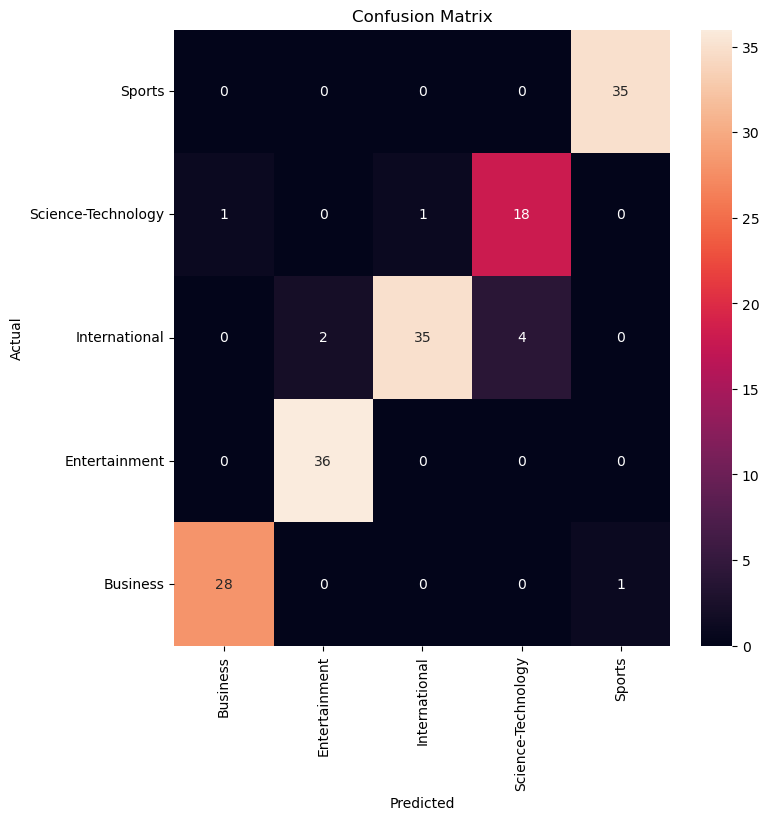

------------------------------------------------------------------------------------------
Classification Report:
                    precision    recall  f1-score   support

          Business       0.97      0.97      0.97        29
     Entertainment       0.95      1.00      0.97        36
     International       0.97      0.85      0.91        41
Science-Technology       0.82      0.90      0.86        20
            Sports       0.97      1.00      0.99        35

          accuracy                           0.94       161
         macro avg       0.94      0.94      0.94       161
      weighted avg       0.95      0.94      0.94       161



In [10]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(128, 64, 128), max_iter=10, alpha=0.005, solver='adam', verbose=10, random_state=seed, tol=1e-4)
model.fit(X_train_vector, y_train_encoded)
predicted_labels = model.predict(X_test_vector)
predicted_labels_decoded = decode_labels(predicted_labels).tolist()
print('RESULTS:')
print('------------------------------------------------------------------------------------------')
print('Accuracy:', accuracy_score(y_test, predicted_labels_decoded))
print('F1 Score:', f1_score(y_test, predicted_labels_decoded, average='weighted'))
print('Recall:', recall_score(y_test, predicted_labels_decoded, average='weighted'))
print('Precision:', precision_score(y_test, predicted_labels_decoded, average='weighted'))
print('------------------------------------------------------------------------------------------')
print('Confusion Matrix:')
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, predicted_labels_decoded), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis()
plt.gca().set_xticklabels(labels, rotation=90)
plt.gca().set_yticklabels(labels, rotation=0)
plt.show()
print('------------------------------------------------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted_labels_decoded))
SKPredictions = predicted_labels_decoded
pd.DataFrame({'Gold Labels': y_test, 'NN Predictions': NNPredictions, 'SK Predictions': SKPredictions}).to_csv('./Results/NeuralNetworkPredictions.csv', index=False)

**Conclusion:**
The results of our own neural network and the one deployed by SKlearn are almost the same.